# Introduction to bias and fairness in Machine Learning

In this tutorial, you will be exposed to the topic of bias in machine learning. More specifically, you will be exploring the UCI Adult dataset to learn about metrics for quantifying bias, method for mitigating bias in machine learning models, and you will get introduced to more advanced approaches for mitigating bias


### Software requirements

In this tutorial, you will need **numpy, pandas, skit-learn, tensorflow and keras**, which are all the machine learning tools that you will be needing in this notebook. If you don't have them installed on your machine, you can learn the tutorial on [Google's colab](https://colab.research.google.com), which has all the tools pre-installed

# 1. Analysing data distributions

In this section, we will look through the data that we have. This will give us an idea of the underlying distributions of the data among different demographics.

Load needed modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

** Load the dataset **

For this step, get the pre-processed adult dataset from [our github repository](https://github.com/heyaudace/ml-bias-fairness/blob/master/data/adult/adult.csv), and store it into your local machine

In [3]:
import os
ADULT_PATH = os.path.join(os.getcwd(), 'data/adult/adult.csv') # Assign this to the location of the dataset

In [4]:
data = pd.read_csv(ADULT_PATH)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [5]:
# Ge the shape of the data
data.shape

(48842, 15)

Let's understand the amount of data by we have, by seeing how the number of datapoints compares among different demographics

In [33]:
def plot_categs(df, category, fignum=1, title="Histogram of number of datapoints"):
    plt.figure(fignum)
    uniques= list(sorted(df[category].unique()))
    counts = [df[df[category] == value].shape[0] for value in uniques]
    size = len(uniques)
    xcoords = list(range(1, size+1))
    plt.bar(xcoords, counts)
    plt.xticks(xcoords, uniques, rotation='vertical' if size >= 5 else 'horizontal')
    plt.title((title if title is not None else ''))
    plt.tight_layout()

## Sex, Race and Native Country

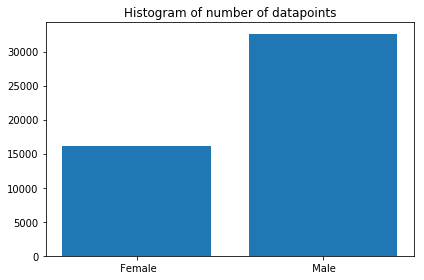

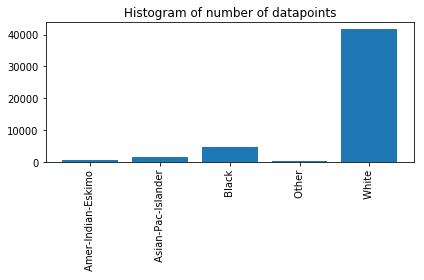

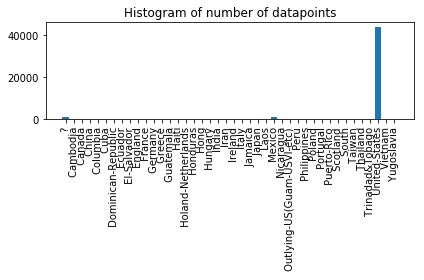

In [34]:
features = ['sex', 'race', 'native-country']
for index, feature in enumerate(features):
    plot_categs(data, feature, fignum=index+1)

# Distribution of education level and occupation

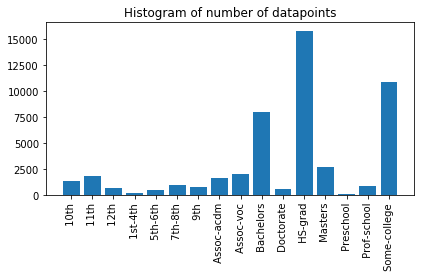

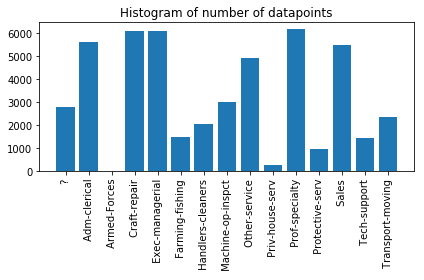

In [35]:
other_features = ['education', 'occupation']
for index, feature in enumerate(other_features):
    plot_categs(data, feature, fignum=index+1)

# Distribution of salary among the general population

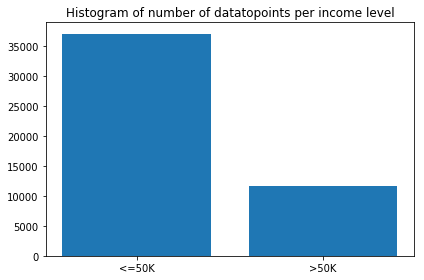

In [37]:
plot_categs(data, 'salary', title="Histogram of number of datatopoints per income level")

## CHECKPOINT 

** Observation ** : The fraction of the population that makes less than 50K is about 3 times the fraction of the
population that earns more than 50K.

** THINK ** : How would this affect the predictor trained on this data?

# Distribution of salary among sex

Let's now explore the distribution of salary among people of Male sex versus people with Female sex

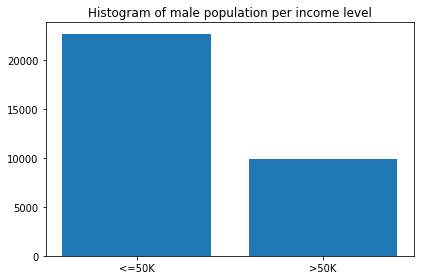

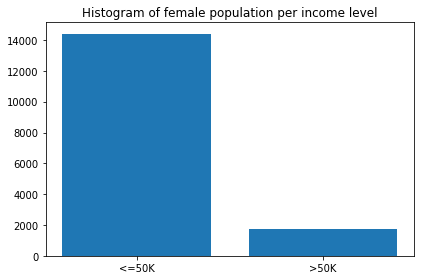

In [39]:
# Examining statistics among_demographics
male_data = data[data.sex == ' Male']
female_data = data[data.sex == ' Female']

plot_categs(male_data, 'salary', fignum=1,title="Histogram of male population per income level")
plot_categs(female_data, 'salary', fignum=2, title="Histogram of female population per income level")

# CHECKPOINT:

**Observation** 
- Fraction of males who make less than \$50K is about twice the fraction of males that make more
- The fraction of females that make less than \$50K is about 7 times the fraction of females that make more

**THINK**: How would this affect the way a predictor trained on this training data treats females versus males? 

## Distribution of race in the dataset

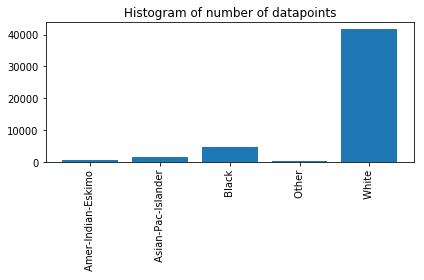

In [54]:
# Examine races in the dataset
plot_categs(data, 'race')

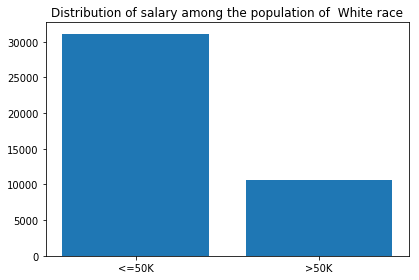

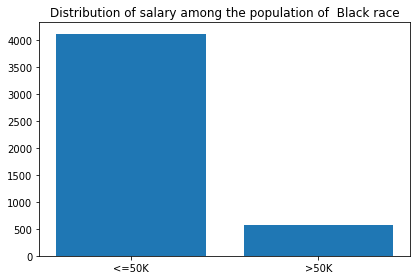

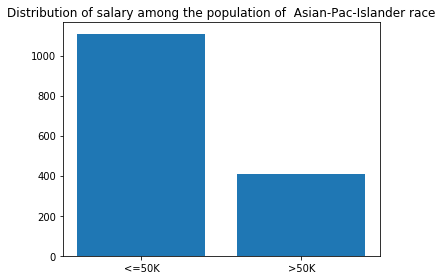

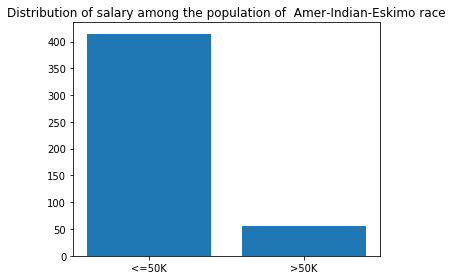

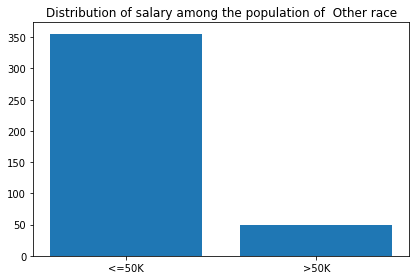

In [55]:
unique_races = data['race'].unique()
for index, race in enumerate(unique_races):
    plot_categs(data[data['race'] == race], 'salary', fignum=index, title = "Distribution of salary among the population of "+race+" race")

# CHECKPOINT
**Observation**:
- Different races have different levels of representation in terms number of datapoints with a given race
- The levels of income distribution among a given race are different 

**THINK**:
- How could this affect the predictions of an algorithm accross different races?

#  Distribution of hours per week

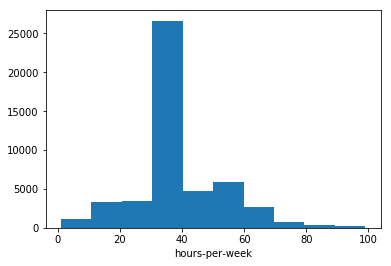

In [53]:
def plot_categ_hists(df, feature, title=None, bins=None, histtype='bar', density=False, normed=None, fignum=1):
    plt.figure(fignum)
    x = df[feature]
    plt.hist(x, bins=bins, density=density, normed=normed, histtype=histtype)
    plt.xlabel(feature)
    plt.title(title if title is not None else '')
plot_categ_hists(data, 'hours-per-week', fignum=1)

# 2 - Preparing features for machine learning predictions

One important step in data science before applying machine learning algorithms is data preparation. In this section, we will be transforming features of our data, so that our dataset can be ready for machine learning

In [736]:
# Create a new dataset to be modified 
datav2 = data.copy()
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Drop missing values
Some of the entries in our dataset are either question marks (' ?') or np.nan. Let's simply ignore such entries

In [737]:
# See features with question marks
[feature for feature in datav2.columns if ' ?' in datav2[feature].unique() or np.nan in datav2[feature].unique()]

/Users/audace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


['workclass', 'occupation', 'native-country']

In [738]:
# Remove all missing values
for feature in datav2.columns:
    datav2[feature] = datav2[feature].replace(' ?', np.nan)
datav2.dropna(how='any', inplace=True)

datav2['native-country'].unique(), datav2['workclass'].unique(), datav2['occupation'].unique()

(array([' United-States', ' Cuba', ' Jamaica', ' India', ' Mexico',
        ' Puerto-Rico', ' Honduras', ' England', ' Canada', ' Germany',
        ' Iran', ' Philippines', ' Poland', ' Columbia', ' Cambodia',
        ' Thailand', ' Ecuador', ' Laos', ' Taiwan', ' Haiti', ' Portugal',
        ' Dominican-Republic', ' El-Salvador', ' France', ' Guatemala',
        ' Italy', ' China', ' South', ' Japan', ' Yugoslavia', ' Peru',
        ' Outlying-US(Guam-USVI-etc)', ' Scotland', ' Trinadad&Tobago',
        ' Greece', ' Nicaragua', ' Vietnam', ' Hong', ' Ireland',
        ' Hungary', ' Holand-Netherlands'], dtype=object),
 array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
        ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object),
 array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
        ' Prof-specialty', ' Other-service', ' Sales', ' Transport-moving',
        ' Farming-fishing', ' Machine-op-inspct', ' Tech-support',
        ' Craft-repai

## Categorize native country as US and Non-US

In [739]:
datav2[datav2['native-country'] == ' United-States'].shape

(41292, 15)

In [740]:
datav2.loc[datav2['native-country']!=' United-States', 'native-country'] = 'Non-US'
datav2.loc[datav2['native-country'] == ' United-States', 'native-country'] = 'US'
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,US,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,US,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,US,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,US,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Non-US,<=50K


# Convert native-country, sex and salary to binary one-hot

In [741]:
FEMALE_LABEL, MALE_LABEL = (0, 1)
US_LABEL, NON_US_LABEL = (0, 1)
HIGH_SALARY_LABEL, LOW_SALARY_LABEL = (0, 1)

In [742]:
datav2['salary'] = datav2['salary'].map({'>50K':HIGH_SALARY_LABEL,'<=50K':LOW_SALARY_LABEL})
datav2['native-country'] = datav2['native-country'].map({'US':US_LABEL,'Non-US':NON_US_LABEL}).astype(int)
datav2['sex'] = datav2['sex'].map({' Male':MALE_LABEL,' Female':FEMALE_LABEL})
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


# Change marital status to single or couple

In [743]:
datav2['marital-status'].unique()

array([' Never-married', ' Married-civ-spouse', ' Divorced',
       ' Married-spouse-absent', ' Separated', ' Married-AF-spouse',
       ' Widowed'], dtype=object)

In [744]:
datav2['marital-status'] = datav2['marital-status'].replace([' Divorced',' Married-spouse-absent',' Never-married',' Separated',' Widowed'],'Single')
datav2['marital-status'] = datav2['marital-status'].replace([' Married-AF-spouse',' Married-civ-spouse'],'Couple')
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Single,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Couple,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,Single,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,Couple,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,Couple,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


In [745]:
COUPLE_STATUS_LABEL, SINGLE_STATUS_LABEL = (0, 1)
datav2['marital-status'] = datav2['marital-status'].map({'Couple':COUPLE_STATUS_LABEL,'Single':SINGLE_STATUS_LABEL})
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,Not-in-family,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,Husband,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,Not-in-family,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,Husband,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,Wife,Black,0,0.0,0.0,40.0,1,1


# Convert relationships to one-hot

Remember that one-hot encoding helps us represent data of multiple categories. Let's do this for relationships

In [746]:
# First convert relationship to integers
rel_map = {' Unmarried':0,' Wife':1,' Husband':2,' Not-in-family':3,' Own-child':4,' Other-relative':5}
datav2['relationship'] = datav2['relationship'].map(rel_map)
datav2.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,3,White,1,2174.0,0.0,40.0,0,1
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,2,White,1,0.0,0.0,13.0,0,1
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,3,White,1,0.0,0.0,40.0,0,1
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,2,Black,1,0.0,0.0,40.0,0,1
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,1,Black,0,0.0,0.0,40.0,1,1
5,37,Private,284582.0,Masters,14.0,0,Exec-managerial,1,White,0,0.0,0.0,40.0,0,1
6,49,Private,160187.0,9th,5.0,1,Other-service,3,Black,0,0.0,0.0,16.0,1,1
7,52,Self-emp-not-inc,209642.0,HS-grad,9.0,0,Exec-managerial,2,White,1,0.0,0.0,45.0,0,0
8,31,Private,45781.0,Masters,14.0,1,Prof-specialty,3,White,0,14084.0,0.0,50.0,0,0
9,42,Private,159449.0,Bachelors,13.0,0,Exec-managerial,2,White,1,5178.0,0.0,40.0,0,0


In [747]:
# Now convert relationship from integer to one-hot
datav2 = pd.get_dummies(datav2, columns=['relationship'])
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,relationship_0,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,White,1,2174.0,0.0,40.0,0,1,0,0,0,1,0,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,White,1,0.0,0.0,13.0,0,1,0,0,1,0,0,0
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,White,1,0.0,0.0,40.0,0,1,0,0,0,1,0,0
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,Black,1,0.0,0.0,40.0,0,1,0,0,1,0,0,0
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,Black,0,0.0,0.0,40.0,1,1,0,1,0,0,0,0


##  Convert race to one-hot

As we did for relationships, we know convert race representation to one-hot encoding

In [748]:
# Convert to integers first
race_map={' White':0,' Amer-Indian-Eskimo':1,' Asian-Pac-Islander':2,' Black':3,' Other':4}
datav2['race']= datav2['race'].map(race_map)
# Convert from integer to one_hot
datav2 = pd.get_dummies(datav2, columns=['race'])
datav2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,...,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,race_0,race_1,race_2,race_3,race_4
0,39,State-gov,77516.0,Bachelors,13.0,1,Adm-clerical,1,2174.0,0.0,...,0,0,1,0,0,1,0,0,0,0
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,0,Exec-managerial,1,0.0,0.0,...,0,1,0,0,0,1,0,0,0,0
2,38,Private,215646.0,HS-grad,9.0,1,Handlers-cleaners,1,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
3,53,Private,234721.0,11th,7.0,0,Handlers-cleaners,1,0.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,28,Private,338409.0,Bachelors,13.0,0,Prof-specialty,0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0


# Transform workclass feature

We first start by categorizing workclass as government, private or without pay

In [749]:
def group_workclass(x):
    if x['workclass'] == ' Federal-gov' or x['workclass']== ' Local-gov' or x['workclass']==' State-gov': return 'govt'
    elif x['workclass'] == ' Private':return 'private'
    elif x['workclass'] == ' Self-emp-inc' or x['workclass'] == ' Self-emp-not-inc': return 'self_employed'
    else: return 'without_pay'
    
datav2['workclass']=datav2.apply(group_workclass, axis=1)

datav2['workclass'] = datav2['workclass'].map({'govt':0,'private':1,'self_employed':2,'without_pay':3})
datav2 = pd.get_dummies(datav2, columns=['workclass'])
datav2.head()

,age,fnlwgt,education,education-num,marital-status,occupation,sex,capital-gain,capital-loss,hours-per-week,...,relationship_5,race_0,race_1,race_2,race_3,race_4,workclass_0,workclass_1,workclass_2,workclass_3
0,39,77516.0,Bachelors,13.0,1,Adm-clerical,1,2174.0,0.0,40.0,...,0,1,0,0,0,0,1,0,0,0
1,50,83311.0,Bachelors,13.0,0,Exec-managerial,1,0.0,0.0,13.0,...,0,1,0,0,0,0,0,0,1,0
2,38,215646.0,HS-grad,9.0,1,Handlers-cleaners,1,0.0,0.0,40.0,...,0,1,0,0,0,0,0,1,0,0
3,53,234721.0,11th,7.0,0,Handlers-cleaners,1,0.0,0.0,40.0,...,0,0,0,0,1,0,0,1,0,0
4,28,338409.0,Bachelors,13.0,0,Prof-specialty,0,0.0,0.0,40.0,...,0,0,0,0,1,0,0,1,0,0


# Convert occupation to one-hot

In [750]:
occupation_map = dict((value, key) for (key, value) in enumerate(datav2.occupation.unique()))
datav2['occupation'] = datav2['occupation'].map(occupation_map)
datav2 = pd.get_dummies(datav2, columns=['occupation'])
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,2174.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


##  Convert capita-gain and capital-loss to categorical

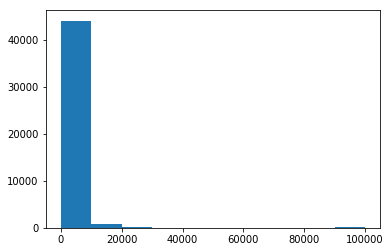

In [751]:
capital_gain, capital_loss, =datav2['capital-gain'], datav2['capital-loss']
plt.hist(capital_gain,bins=None,normed=None)
plt.show()

In [752]:
datav2.loc[(datav2['capital-gain'] > 0),'capital-gain'] = 1
datav2.loc[(datav2['capital-gain'] == 0 ,'capital-gain')]= 0
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,1.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


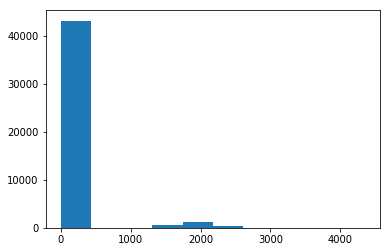

In [753]:
x=datav2['capital-loss']
plt.hist(x,bins=None)
plt.show()

In [754]:
datav2.loc[(datav2['capital-loss'] > 0),'capital-loss'] = 1
datav2.loc[(datav2['capital-loss'] == 0 ,'capital-loss')]= 0
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,39,77516.0,Bachelors,13.0,1,1,1.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,83311.0,Bachelors,13.0,0,1,0.0,0.0,13.0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,215646.0,HS-grad,9.0,1,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,234721.0,11th,7.0,0,1,0.0,0.0,40.0,0,...,0,0,0,0,0,0,0,0,0,0
4,28,338409.0,Bachelors,13.0,0,0,0.0,0.0,40.0,1,...,0,0,0,0,0,0,0,0,0,0


# 3. Predicting individual's income

In [755]:
continuous_features = ['age', 'fnlwgt', 'education-num', 'hours-per-week']
X = datav2[continuous_features]
datav2[continuous_features] = (X - np.mean(X))/ np.std(X)
datav2.head()

,age,fnlwgt,education,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,Bachelors,1.128753,1,1,1.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,Bachelors,1.128753,0,1,0.0,0.0,-2.326738,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.041455,0.245284,HS-grad,-0.438122,1,1,0.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
3,1.093385,0.425853,11th,-1.221559,0,1,0.0,0.0,-0.078120,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.798015,1.407393,Bachelors,1.128753,0,0,0.0,0.0,-0.078120,1,...,0,0,0,0,0,0,0,0,0,0


In [756]:
datav2 = datav2.drop(['education'], axis=1)

Divide data into training, validatin and test dataset

50% training data, 20% validation data, 30% test data

In [757]:
import math, random
def shuffled_df(df, random_state = 1):
    """
    Return randomly shufled dataframe
    """
    df_copy = df.copy()
    ## Get shuffled sample of size 100%
    df_copy.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_copy

def split_df(X, y, train_size=.5):
    """
    Return Xtrain, Ytrain, Xtest, Ytest. No randomization
    """
    assert X.shape[0] == y.shape[0], "Unequal number of datapoints"
    nrows, ncols = X.shape
    ntrain = math.floor(train_size*nrows)
    Xtrain, Xtest = X[:ntrain], X[ntrain:]
    Ytrain, Ytest = y[:ntrain], y[ntrain:]
    return Xtrain, Xtest, Ytrain, Ytest

In [840]:
data_shuffled = shuffled_df(datav2)
X = data_shuffled.drop(['salary'], axis=1)
y = data_shuffled['salary']

train_size = 0.7
Xtrain, Xtest, Ytrain, Ytest = split_df(X, y, train_size =0.7)
Xtrain, Xval, Ytrain, Yval = split_df(Xtrain, Ytrain, train_size=0.8)

In [815]:
print ("Train dataset: {0}{1}".format(Xtrain.shape, Ytrain.shape))
print ("Validation dataset: {0}{1}".format(Xval.shape, Yval.shape))
print ("Test dataset: {0}{1}".format(Xtest.shape, Ytest.shape))

Train dataset: (25324, 38)(25324,)
Validation dataset: (6331, 38)(6331,)
Test dataset: (13567, 38)(13567,)


In [816]:
# Let's select algorithms for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [817]:
models = []
names = ['LR','Random Forest','Neural Network','GaussianNB','DecisionTreeClassifier','SVM',]

models.append((LogisticRegression()))
models.append((RandomForestClassifier(n_estimators=100)))
models.append((MLPClassifier()))
models.append((GaussianNB()))
models.append((DecisionTreeClassifier()))
#models.append((SVC()))

In [818]:
print(models)

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_s

In [819]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [820]:
kfold = model_selection.KFold(n_splits=5,random_state=7)

for i in range(0,len(models)):    
    cv_result = model_selection.cross_val_score(models[i],Xtrain,Ytrain,cv=kfold,scoring='accuracy')
    
    score=models[i].fit(Xtrain,Ytrain)
    prediction = models[i].predict(Xval)
    acc_score = accuracy_score(Yval,prediction)     
    print ('-'*40)
    print ('{0}: {1}'.format(names[i],acc_score))

----------------------------------------
LR: 0.833517611751698
----------------------------------------
Random Forest: 0.8276733533407045


/Users/audace/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


----------------------------------------
Neural Network: 0.8407834465329331
----------------------------------------
GaussianNB: 0.573053230137419
----------------------------------------
DecisionTreeClassifier: 0.7864476386036962


# Predict on test data

In [821]:
model = MLPClassifier()
model.fit(Xtrain,Ytrain)
prediction = model.predict(Xtest)

In [930]:
print ('-'*40)
print ('Accuracy score:')
print (accuracy_score(Ytest,prediction))

----------------------------------------
Accuracy score:
0.8387263212206089


# Evaluating Algorithm's performance accross different features

In [931]:
Xtrain.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,1.128753,1,1,1.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,1.128753,0,1,0.0,0.0,-2.326738,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.041455,0.245284,-0.438122,1,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.093385,0.425853,-1.221559,0,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.798015,1.407393,1.128753,0,0,0.0,0.0,-0.078120,1,0,...,0,0,0,0,0,0,0,0,0,0


In [932]:
test_df = Xtest.copy()
test_df['salary'] = Ytest
test_df['pred'] = pd.Series(prediction, index=test_df.index)
test_df['accurate'] = (test_df['pred'] == test_df['salary'])
test_df.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary,pred,accurate
34178,-1.478919,0.321232,-1.221559,1,1,0.0,0.0,-1.743763,0,0,...,0,0,0,0,0,0,0,1,1,True
34179,0.639449,-0.071544,-0.046403,1,0,0.0,0.0,-1.493917,0,1,...,0,0,0,0,1,0,0,1,1,True
34180,-1.100639,-0.760339,-0.046403,1,1,0.0,0.0,-1.743763,1,0,...,0,0,0,0,0,0,0,1,1,True
34181,1.244697,-0.367460,-0.046403,0,1,0.0,1.0,0.338291,0,0,...,0,0,0,0,0,0,0,0,0,True
34182,1.698633,-1.425687,-0.438122,0,1,0.0,0.0,-0.494531,0,0,...,0,0,0,1,0,0,0,1,1,True


# Understanding gender bias in machine learning predictions

In [933]:
# TODO(audace): Improve the method
def evaluate_gender_performance(predictor, results_df):   
    def printline():
        print('-------------------------------------------------')
    
    summaries = {}
    overall_accuracy = results_df.accurate.mean()
    summaries['accuracy_overall'] = overall_accuracy
    printline()
    print("\n1.Overall accuracy: ", overall_accuracy)
    
    printline()
    
    # Accuracy accross gender
    print("\n2.Accuracy accross gender \n ")
    printline
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        accuracy_for_gender = rows.accurate.mean();
        summaries['accuracy_'+gender[1]] = accuracy_for_gender
        print("P(((high, HIGH) or (low, LOW)) |", gender[1], "): ", accuracy_for_gender)
    printline()
    
    print("\n3.Positive Rates: \n")
    # Loan chance given gender
    for gender in [(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]:
        rows = results_df[results_df.sex==gender[0]]
        positive_rate_for_gender = (rows['pred'] ==HIGH_SALARY_LABEL).mean()
        summaries['positive_rate_'+gender[1]] = positive_rate_for_gender
        print("P(high|", gender[1], "): ", positive_rate_for_gender)
    
    printline()
    
    print("\n4. True positive and True negative rates")
    
    printline()
    
    for index, gender in enumerate([(FEMALE_LABEL, "Female"), (MALE_LABEL, "Male")]):
        
        print("\n4."+("i")*(1+index), " True positive and negative rates on sex="+gender[1], "\n")
        rows = results_df[results_df.sex==gender[0]]
        
        high_income = rows[rows.salary== HIGH_SALARY_LABEL]
        low_income=rows[rows.salary == LOW_SALARY_LABEL]
        
        assert high_income.salary.mean() == HIGH_SALARY_LABEL, "high_mean: " + str(high_income.salary.mean())
        assert low_income.salary.mean() == LOW_SALARY_LABEL, "low_mean: " + str(low_income.salary.mean())
        
        high_pred = rows[rows.pred == HIGH_SALARY_LABEL]
        low_pred = rows[rows.pred == LOW_SALARY_LABEL]
        
        assert high_pred.pred.mean() == HIGH_SALARY_LABEL, "high_pred_mean: " + str(high_pred.pred.mean())
        assert low_pred.pred.mean() == LOW_SALARY_LABEL, "low_pred_mean: " + str(low_pred.pred.mean())
        
        printline() 
        accuracy_on_the_positive = high_income.accurate.mean()
        accuracy_on_the_negative = low_income.accurate.mean()
        summaries['accuracy_on_the_positive_'+gender[1]] = accuracy_on_the_positive
        summaries['accuracy_on_the_negative_'+gender[1]] = accuracy_on_the_negative
        
        print(str.format("P((high, HIGH)| HIGH,{0})", gender[1]), ": ",accuracy_on_the_positive)
        print(str.format("P((low, LOW)| LOW,{0})", gender[1]), ":",accuracy_on_the_negative)
        
        printline()
        accuracy_on_the_favoured = high_pred.accurate.mean()
        accuracy_on_the_unfavoured = low_pred.accurate.mean()
        summaries['accuracy_on_the_favoured_'+gender[1]] = accuracy_on_the_favoured
        summaries['accuracy_on_the_unfavoured_'+gender[1]] = accuracy_on_the_unfavoured
        print(str.format("P((high,HIGH) | high, {0})", gender[1]), ": ",accuracy_on_the_favoured) # TODO: Wrong
        print(str.format("P((low,LOW) |low,{0})", gender[1]), ":",accuracy_on_the_unfavoured)
        
        
    return summaries
        
        

In [934]:
summary = evaluate_gender_performance(randomForest,df_testdata)
summary

-------------------------------------------------

1.Overall accuracy:  0.8444018574482199
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.9189128481581311
P(((high, HIGH) or (low, LOW)) | Male ):  0.8080087767416346
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.07749326145552561
P(high| Male ):  0.2607789358200768
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.48406374501992033
P((low, LOW)| LOW,Female) : 0.9741772151898734
-------------------------------------------------
P((high,HIGH) | high, Female) :  0.7043478260869566
P((low,LOW) |low,Female) : 0.9369369369369369

4.ii  True positive and negative rates on sex=Male 

-----------

{'accuracy_overall': 0.8444018574482199,
 'accuracy_Female': 0.9189128481581311,
 'accuracy_Male': 0.8080087767416346,
 'positive_rate_Female': 0.07749326145552561,
 'positive_rate_Male': 0.2607789358200768,
 'accuracy_on_the_positive_Female': 0.48406374501992033,
 'accuracy_on_the_negative_Female': 0.9741772151898734,
 'accuracy_on_the_favoured_Female': 0.7043478260869566,
 'accuracy_on_the_unfavoured_Female': 0.9369369369369369,
 'accuracy_on_the_positive_Male': 0.6111308046791918,
 'accuracy_on_the_negative_Male': 0.896250397203686,
 'accuracy_on_the_favoured_Male': 0.7252839713925116,
 'accuracy_on_the_unfavoured_Male': 0.8371920451172454}

## Introducing Bias metrics

The two most used bias metrics are **statistical parity**, and **equality of opportunity**.

1. **Statistical parity**

Suppose you have a population X, and there is a known subset S that is a protected group of the population. For example, let's S represents the people who identify as Male. A Machine Learning classifier is said to have **Statistical parity** if and only if the probability that an individual randomly drawn from S is classified as favorable/unfavorable is equal to the probability that an individual randomly drawn from the complement of S in the population X classified as favorable/unfavorable. Simply, the prediction must be uncorrelated with any sensitive attribute.

2. **Equality of Opportunity**

The principle of equality of opportunity says that "individuals who qualify for a desirable outcome should have an equal chance of being classified for this outcome"[1].

# 3. Mitigating bias through database re-balancing

## Attempt 1. Omitting protected attributes from training data

Removing sensitive attributes is useful when we know what the protected are. However, this can still be problematic since other attributes might be correlated with the sensitive features, therefore removing sensitive features is not always enough to remove all the bias.

In [940]:
#Xtrain_no_sex = Xtrain.drop(["sex"], axis=1)
#Xtest_no_sex = Xtest.drop(["sex"], axis=1)
predictor = MLPClassifier()
predictor.fit(Xtrain.drop(['sex'], axis=1), Ytrain)
predictions = rf2.predict(Xtest.drop(['sex'], axis=1))

In [941]:
df2_testdata = Xtest.copy()
assert "sex" in list(df2_testdata.columns), ("columns: ", list(df2_testdata.columns))

df2_testdata['salary'] = Ytest
pred_df = pd.Series(predictions, index=df2_testdata.index)

df2_testdata['pred'] = pred_df

df2_testdata['accurate'] = (df2_testdata['pred'] == df2_testdata['salary'])
df2_testdata.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,relationship_0,...,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13,salary,pred,accurate
34178,-1.478919,0.321232,-1.221559,1,1,0.0,0.0,-1.743763,0,0,...,0,0,0,0,0,0,0,1,1,True
34179,0.639449,-0.071544,-0.046403,1,0,0.0,0.0,-1.493917,0,1,...,0,0,0,0,1,0,0,1,1,True
34180,-1.100639,-0.760339,-0.046403,1,1,0.0,0.0,-1.743763,1,0,...,0,0,0,0,0,0,0,1,1,True
34181,1.244697,-0.367460,-0.046403,0,1,0.0,1.0,0.338291,0,0,...,0,0,0,0,0,0,0,0,0,True
34182,1.698633,-1.425687,-0.438122,0,1,0.0,0.0,-0.494531,0,0,...,0,0,0,1,0,0,0,1,1,True


# Analysing performance

In [943]:
summaries_blindness = evaluate_gender_performance(predictor, df2_testdata)
summaries_blindness

-------------------------------------------------

1.Overall accuracy:  0.8415272352030663
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.9162174303683738
P(((high, HIGH) or (low, LOW)) | Male ):  0.8050466264399342
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.09546271338724169
P(high| Male ):  0.2665935271530444
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.5517928286852589
P((low, LOW)| LOW,Female) : 0.9625316455696202
-------------------------------------------------
P((high,HIGH) | high, Female) :  0.6517647058823529
P((low,LOW) |low,Female) : 0.9441271417928979

4.ii  True positive and negative rates on sex=Male 

------------

{'accuracy_overall': 0.8415272352030663,
 'accuracy_Female': 0.9162174303683738,
 'accuracy_Male': 0.8050466264399342,
 'positive_rate_Female': 0.09546271338724169,
 'positive_rate_Male': 0.2665935271530444,
 'accuracy_on_the_positive_Female': 0.5517928286852589,
 'accuracy_on_the_negative_Female': 0.9625316455696202,
 'accuracy_on_the_favoured_Female': 0.6517647058823529,
 'accuracy_on_the_unfavoured_Female': 0.9441271417928979,
 'accuracy_on_the_positive_Male': 0.6157390996100673,
 'accuracy_on_the_negative_Male': 0.8898951382268827,
 'accuracy_on_the_favoured_Male': 0.7148148148148148,
 'accuracy_on_the_unfavoured_Male': 0.837845923709798}

## Attempt 2. Balancing training data between different demographics

In this approach, we attempt to balance the size of the population with each sensitive attribute in the training data. Here we combine it with omitting the protected group

In [944]:
datav3 = datav2.copy()
datav3.head(2)

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.034201,-1.062295,1.128753,1,1,1.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.866417,-1.007438,1.128753,0,1,0.0,0.0,-2.326738,0,1,...,0,0,0,0,0,0,0,0,0,0


In [945]:
males, females = datav3[datav3.sex == MALE_LABEL], datav3[datav3.sex==FEMALE_LABEL]
sampled_males = males.sample(n=int(min(females.shape[0], males.shape[0]))).reset_index(drop=True)
sampled_males.shape, females.shape

((14695, 39), (14695, 39))

In [946]:
from sklearn.model_selection import train_test_split

In [947]:
combined = pd.concat([sampled_males, females]).sample(frac=1).reset_index(drop=True)
combined.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,-1.630231,-1.097282,-0.829840,1,0,0.0,0.0,-2.743149,0,1,...,0,1,0,0,0,0,0,0,0,0
1,0.109857,0.146162,-0.438122,1,0,0.0,0.0,-0.327966,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-0.117111,-0.514007,1.128753,0,1,0.0,1.0,1.587523,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.396009,-1.134343,-0.438122,0,0,1.0,0.0,-0.078120,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0.185513,-1.491411,1.128753,0,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,1,0,0,0,0


In [948]:
Xvals=combined.drop(["salary"], axis=1)
Yvals = combined["salary"]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=0.25)
x_train.shape, x_test.shape

((22042, 38), (7348, 38))

In [949]:
predictor = MLPClassifier()
predictor.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = predictor.predict(x_test.drop(['sex'], axis=1))

df3_testdata = x_test.copy()
df3_testdata['salary'] = y_test
pred_df = pd.Series(predictions, index=x_test.index)

df3_testdata['pred'] = pred_df

df3_testdata['accurate'] = (df3_testdata['pred'] == df3_testdata['salary'])

In [951]:
summaries_balanced_gender = evaluate_gender_performance(predictor, df3_testdata)

-------------------------------------------------

1.Overall accuracy:  0.8569678824169842
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.9166895793236184
P(((high, HIGH) or (low, LOW)) | Male ):  0.7984370789544597
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.08578498762716524
P(high| Male ):  0.27081649151172194
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.5115089514066496
P((low, LOW)| LOW,Female) : 0.9654959950708565
-------------------------------------------------
P((high,HIGH) | high, Female) :  0.6410256410256411
P((low,LOW) |low,Female) : 0.9425563909774436

4.ii  True positive and negative rates on sex=Male 

-----------

### Attempt 3: Balacing training data with respect to gender and favorable/unfavorable outcomes

In this this approach, we will balance accross the size of the population in each demographic with a given outcome.
I.e We will balance the data so that the size of the population with high and low income are is equal for each gender

In [978]:
# Want equal number of males, females, who earn high and low income in the training set
males = datav3[(datav3.sex==MALE_LABEL)]
females = datav3[(datav3.sex==FEMALE_LABEL)]
males_high = males[(males.salary == HIGH_SALARY_LABEL)]
males_low = males[(males.salary == LOW_SALARY_LABEL)]
females_high = females[(females.salary == HIGH_SALARY_LABEL)]
females_low = females[(females.salary == LOW_SALARY_LABEL)]

males_high.shape, males_low.shape, females_high.shape, females_low.shape

((9539, 39), (20988, 39), (1669, 39), (13026, 39))

In [979]:
# Todo: Augment data, perform logistic regression, etc
_n = min((x.shape[0] for x in [males_high, males_low, females_high, females_low]))
_n

1669

In [980]:
_males_high = males_high.sample(n=_n).reset_index(drop=True)
_males_low = males_low.sample(n=_n).reset_index(drop=True)
_females_high = females_high.sample(n=_n).reset_index(drop=True)
_females_low = females_low.sample(n=_n).reset_index(drop=True)
_combined = pd.concat([_males_high, _males_low, _females_high, _females_low]).sample(frac=1).reset_index(drop=True)
_combined.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,-0.798015,-0.044243,-1.221559,1,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-1.327607,1.061931,-1.221559,1,0,0.0,0.0,-0.910942,1,1,...,0,1,0,0,0,0,0,0,0,0
2,-1.176295,0.993641,-0.438122,1,0,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.109857,0.003666,-0.046403,1,0,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2.530849,-0.487388,-1.221559,0,1,0.0,0.0,-1.743763,0,1,...,0,0,0,0,0,0,1,0,0,0


In [981]:
_males_high.shape

(1669, 39)

In [982]:
Xvals=_combined.drop(["salary"], axis=1)
Yvals = _combined["salary"]
x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=0.25)

rf4 = MLPClassifier()
#rf4 = LogisticRegression()
rf4.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = rf4.predict(x_test.drop(['sex'], axis=1))

df4_testdata = x_test.copy()
df4_testdata['salary'] = y_test
pred_df = pd.Series(predictions, index=x_test.index)

df4_testdata['pred'] = pred_df

df4_testdata['accurate'] = (df4_testdata['pred'] == df4_testdata['salary'])

In [983]:
summaries_balanced_gender_outcome = evaluate_gender_performance(rf4, df4_testdata)

-------------------------------------------------

1.Overall accuracy:  0.8136608747753146
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.849502487562189
P(((high, HIGH) or (low, LOW)) | Male ):  0.7803468208092486
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.5186567164179104
P(high| Male ):  0.5341040462427745
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.854066985645933
P((low, LOW)| LOW,Female) : 0.844559585492228
-------------------------------------------------
P((high,HIGH) | high, Female) :  0.8561151079136691
P((low,LOW) |low,Female) : 0.8423772609819121

4.ii  True positive and negative rates on sex=Male 

----------------

# Attempt 4: Balancing as in attempt 3, but by relative sizes

In this approach, we keep the relative sizes(ratio) of the populatin with a given outcome equal among each member of the protected group

In [991]:
females_high.shape, females_low.shape, males_high.shape, males_low.shape

((1669, 39), (13026, 39), (9539, 39), (20988, 39))

## TODO(audace): Explain

In [992]:
ratio = males_high.shape[0]/males_low.shape[0]
n_females_high = females_high.shape[0]
n_females_low = int(n_females_high / ratio)

_males_low = males_low.copy()
_males_high = males_high.copy()
_females_high = females_high.copy()

_females_low = females_low.sample(n=n_females_low).reset_index(drop=True)

In [993]:
_combined = pd.concat([_males_high, _males_low, _females_high, _females_low]).sample(frac=1).reset_index(drop=True)
_combined.head()

,age,fnlwgt,education-num,marital-status,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,...,occupation_4,occupation_5,occupation_6,occupation_7,occupation_8,occupation_9,occupation_10,occupation_11,occupation_12,occupation_13
0,0.412481,2.026233,0.345316,1,1,0.0,0.0,0.338291,0,1,...,0,1,0,0,0,0,0,0,0,0
1,-0.722359,-0.402116,0.737034,1,1,0.0,0.0,-0.078120,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.034201,-1.034899,1.128753,1,1,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
3,-0.873671,-0.694473,1.128753,1,0,0.0,0.0,-0.078120,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.715105,-0.665137,2.303909,0,1,0.0,0.0,-0.078120,1,0,...,0,0,0,0,0,0,0,0,0,0


In [987]:
Xvals=_combined.drop(["salary"], axis=1)
Yvals = _combined["salary"]
x_train, x_test, y_train, y_test = train_test_split(Xvals, Yvals, test_size=0.25)

rf4 = MLPClassifier()
#rf4 = LogisticRegression()
rf4.fit(x_train.drop(['sex'], axis=1), y_train)
predictions = rf4.predict(x_test.drop(['sex'], axis=1))

df4_testdata = x_test.copy()
df4_testdata['salary'] = y_test
pred_df = pd.Series(predictions, index=x_test.index)

df4_testdata['pred'] = pred_df

df4_testdata['accurate'] = (df4_testdata['pred'] == df4_testdata['salary'])

In [989]:
summaries_rebalanced_gender_outcome = evaluate_gender_performance(rf4, df4_testdata)

-------------------------------------------------

1.Overall accuracy:  0.8105274896843984
-------------------------------------------------

2.Accuracy accross gender 
 
P(((high, HIGH) or (low, LOW)) | Female ):  0.8495762711864406
P(((high, HIGH) or (low, LOW)) | Male ):  0.8032048735266852
-------------------------------------------------

3.Positive Rates: 

P(high| Female ):  0.2944915254237288
P(high| Male ):  0.3120116540855516
-------------------------------------------------

4. True positive and True negative rates
-------------------------------------------------

4.i  True positive and negative rates on sex=Female 

-------------------------------------------------
P((high, HIGH)| HIGH,Female) :  0.7383177570093458
P((low, LOW)| LOW,Female) : 0.8977732793522267
-------------------------------------------------
P((high,HIGH) | high, Female) :  0.7577937649880095
P((low,LOW) |low,Female) : 0.8878878878878879

4.ii  True positive and negative rates on sex=Male 

-------------

In [990]:
# TODO: Provide explanations for the rebalancing steps
# TODO: Provide visualizations of summary statistics

# 5. Mitigating bias through customized regularization

# 6. Comparing approaches

# 7. Intro to adversarial de-biasing

# 8. Conclusion

**9. References**

[1]. [Google AI blog, Equal opportunity in Machine Learning](https://ai.googleblog.com/2016/10/equality-of-opportunity-in-machine.html)

[2]. [Towards Data Science, a Tutoria on Fairness in Machine Learning](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb)

[3]. [Jeremy Kun, One definition of fairness in machine learning](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)